In [373]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [374]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/CMU_DataScience/master/lung.csv?fbclid=IwAR1OOGr8WfNN82y__IvNDRijxvgHGDgmYkWylUcR6MbGcLJcRlgZLCESqj8.csv',header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,1,-0.953518,-0.433265,-0.926334,-0.878343,-0.940477,-0.881761,-0.555303,-0.866727,-0.339190,...,0.111509,-0.842061,-0.984096,-0.641238,-0.611943,-0.852940,-0.891501,-0.737089,-0.879686,-0.998865
1,1,-0.976293,-0.750423,-0.941069,-0.980535,-0.994048,-0.925679,-0.844926,-0.942945,-0.778852,...,0.256599,-0.918326,-0.997074,-0.912676,-0.895525,-0.985294,-0.945752,-0.768386,-0.942223,-0.999525
2,1,-0.663669,-0.491751,-0.893186,-0.854013,-0.934524,-0.842909,-0.792472,-0.907733,-0.490566,...,0.184607,-0.844687,-0.969846,-0.038363,-0.425380,-0.887256,-0.938516,-0.729780,-0.903817,-0.979734
3,1,-0.852158,-0.730928,-0.697973,-0.970803,-0.928571,-0.940880,-0.621438,-0.958102,-0.739355,...,0.496361,-0.900450,-0.989313,-0.681212,-0.701494,-0.936275,-0.978300,-0.814291,-0.920470,-0.992083
4,1,-0.987727,-0.858310,-0.985267,-0.975669,-1.000000,-0.988176,-0.908780,-0.938043,-0.861778,...,0.565058,-0.545379,-0.996183,-0.910572,-0.880595,-0.990196,-1.000000,-0.854985,-0.555620,-0.988864


In [375]:
df.shape

(632, 1281)

In [376]:
A = df.isnull().sum(axis=0)
A

0       0
1       0
2       0
3       0
4       0
       ..
1276    0
1277    0
1278    0
1279    0
1280    0
Length: 1281, dtype: int64

In [377]:
nan = np.array(A)
nan

array([0, 0, 0, ..., 0, 0, 0])

In [378]:
pel_class = np.unique(df[0])
pel_class

array([0, 1])

In [379]:
pel_value = [sum(df[0]==pel_class[0]),
             sum(df[0]==pel_class[1])]
pel_value

[304, 328]

In [380]:
y = df[0].values
X = df.drop([0],axis = 1).values

In [381]:
X = np.array(X)
y = np.array(y)

In [382]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X, y = sm.fit_resample(X, y)

In [383]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [384]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [385]:
np.max(X_train_norm,0)

array([1., 1., 1., ..., 1., 1., 1.])

In [386]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fs = SelectKBest(chi2, k=1000) #เลือกมาเท่าจำนวนที่กำหนด
fs.fit(X_train_norm, y_train)
X_train_norm = fs.transform(X_train_norm)
X_test_norm = fs.transform(X_test_norm)

In [387]:
X_train_norm.shape

(524, 500)

In [388]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100],
    'min_samples_leaf' : [0.25,0.5,1],
    'max_features': ['auto', 'sqrt'],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 5)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
10CV accuracy : 70.03846153846155


In [389]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 64.39393939393939


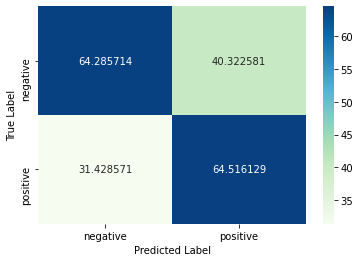

In [390]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [391]:
X_test_norm.shape

(132, 500)

In [392]:
df_test = pd.read_csv('https://raw.githubusercontent.com/plenoi/CMU_DataScience/master/lung_test.csv?fbclid=IwAR1mzam6YwpWkpA8RcvF7-WgpVp2Ie2RhuPfH5H2-uHdtr9VP6engeFCZgY.csv',header = None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,1,-0.979046,-0.716633,-0.981584,-0.961070,-0.964285,-0.962839,-0.849486,-0.900600,-0.732778,...,-0.007953,-0.835510,-0.991348,-0.860071,-0.925373,-1.000000,-1.000000,-0.581632,-0.841275,-0.997440
1,1,-0.887534,-0.057599,-0.963168,-0.941605,-0.958333,-0.915544,-0.473192,-0.694227,-0.081178,...,0.137629,-0.508157,-0.921880,-0.315089,0.074620,-0.897059,-0.949368,-0.727701,-0.545253,-0.966538
2,1,-0.976713,-0.802425,-0.970534,-0.985401,-0.988095,-0.961150,-0.831243,-0.907733,-0.740678,...,0.281941,-0.770071,-0.989058,-0.701209,-0.932835,-1.000000,-0.996383,-0.749610,-0.756818,-0.993245
3,1,-0.961500,-0.645135,-0.944753,-0.902674,-0.970238,-0.917232,-0.753708,-0.845328,-0.591923,...,0.445740,-0.560465,-0.972264,-0.674904,-0.305949,-0.872551,-0.949368,-0.640058,-0.580938,-0.991529
4,1,-0.958373,-0.249974,-0.845303,-0.892944,-0.904763,-0.903720,-0.377416,-0.864943,-0.286527,...,0.357187,-0.798273,-0.983715,-0.585479,-0.365677,-0.833334,-0.887884,-0.826811,-0.819876,-0.996596


In [393]:
yt = df_test[0].values
Xt = df_test.drop([0],axis = 1).values

In [394]:
X_test = scaler.transform(Xt)
X_test_n = fs.transform(X_test)

In [395]:
y_predict = clf.predict(X_test_n)
print("Test accuracy : "+str(sum(yt == y_predict)/len(yt)*100))

Test accuracy : 74.63235294117648
